In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from moviepy.editor import *
import cv2
import moviepy
import sys
import random
import tensorflow.keras.layers as tfKL
import sklearn
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
import random
import pickle
import pandas as pd
import gc
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Concatenate, Input, Lambda,LSTM,Reshape
from tensorflow.keras.models import Model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2383872/45929032 bytes (5.2%)5480448/45929032 bytes (11.9%)8806400/45929032 bytes (19.2%)12091392/45929032 bytes (26.3%)15400960/45929032 bytes (33.5%)18964480/45929032 bytes (41.3%)22315008/45929032 bytes (48.6%)25755648/45929032 bytes (56.1%)29237248/45929032 bytes (63.7%)32595968/45929032 bytes (71.0%)36061184/45929032 bytes (78.5%)39346176/45929032 bytes (85.7%)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
mainPath="/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND" 

In [5]:
nCategories=8

In [6]:
partition ={}
labels ={}
partition['train']=list()
partition['validation']=list()
partition['test']=list()
def mapCatToNumber(file1):
  strings=[]
  for cat in os.listdir(file1):
    strings.append(cat)
  stringsS=sorted(strings)
  answer={}
  for i in range(len(stringsS)):
    answer[stringsS[i]]=i
  return answer
mappingCatToN=mapCatToNumber(mainPath)
print(mappingCatToN)

{'accident': 0, 'call': 1, 'doctor': 2, 'help': 3, 'hot': 4, 'lose': 5, 'pain': 6, 'thief': 7}


In [7]:
for category in os.listdir(mainPath):
  print(category)
  vidL=[]
  for video in os.listdir(os.path.join(mainPath,category)):
    vidL.append(os.path.join(mainPath,category,video))
  lenVidL=len(vidL)
  trainLen=(int)(3*lenVidL/4)
  testLen=int(lenVidL/10)
  valLen=lenVidL-trainLen-testLen
  print(trainLen," ",valLen," ",testLen)
  random.shuffle(vidL)
  for i in range(lenVidL):
    labels[vidL[i]]=mappingCatToN[category]
    if i<trainLen:
      partition['train'].append(vidL[i])
    elif i<trainLen+valLen:
      partition['validation'].append(vidL[i])
    else:
      partition['test'].append(vidL[i])

accident
39   8   5
call
39   8   5
thief
37   8   5
pain
39   8   5
lose
30   6   4
doctor
39   8   5
hot
39   8   5
help
39   8   5


In [8]:
print(np.shape(partition['train']))
print(np.shape(partition['validation']))
print(np.shape(partition['test']))

(301,)
(62,)
(39,)


In [9]:
def prepVids(partition=partition,nSubsequences=5,nLookback=4,frameSize=(80,80)):
  vids={}
  for vid in partition['train']+partition['validation']+partition['test']:
    vids[vid]=np.empty((nSubsequences,nLookback,frameSize[0],frameSize[1],3),dtype=int)
    try:
      vidObj = moviepy.editor.VideoFileClip(vid)
    except IOError as e:
      errno, strerror = e.args
      print(errno)
      print(strerror)
    video_duration = int(vidObj.duration)   
    nFrames=nSubsequences*nLookback
    array=np.empty(shape=(nFrames,frameSize[0],frameSize[1],3))
    for k in range(nFrames):
      frame=vidObj.get_frame((k+1)*video_duration/(nFrames*1.0))
      frameR=Image.fromarray(frame).convert("RGB")
      frame2=frameR.resize(frameSize)
      array[k]=np.array(frame2)
      del frame,frameR,frame2
    # vids[vid]=array
    vids[vid]=np.reshape(array,(nSubsequences,nLookback,frameSize[0],frameSize[1],3))
    del array
    gc.collect()
  gc.collect()
  return vids

In [10]:
with tf.device('/device:GPU:0'):
  Tframes=20
  nSubsequences=5
  nLookback=4
  frameSize=(80,80)
  begin=time.time()
  vids=prepVids(frameSize=frameSize,nSubsequences=nSubsequences,nLookback=nLookback)
  end=time.time()
  print("Time for prep: ",end-begin)

Time for prep:  304.12723207473755


In [11]:
gc.collect()

0

In [12]:
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels,nSubsequences,nLookback, batch_size=32, dim=(20,224,224,3), n_classes=8, shuffle=True):
    'Initialization'
    self.dim = dim
    self.nSubsequences = nSubsequences
    self.nLookback = nLookback
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    n1=len(list_IDs_temp)
    X = np.empty((self.batch_size, *self.dim),dtype=int)
    y = np.empty((self.batch_size), dtype=int)
    # X = np.empty((n1, *self.dim),dtype=int)
    # y = np.empty((n1), dtype=int)
    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Store sample
      # X[i,] = np.load('data/' + ID + '.npy')
      ######
      # print(ID)
      # try:
      #   vidObj = moviepy.editor.VideoFileClip(ID)
      # except IOError as e:
      #   errno, strerror = e.args
      #   print(errno)
      #   print(strerror)
      # video_duration = int(vidObj.duration)   
      # nFrames=self.dim[0]
      # array=np.empty(shape=(nFrames,self.dim[1],self.dim[2],3))
      # frameSize=(self.dim[1],self.dim[2])
      # for k in range(nFrames):
      #   frame=vidObj.get_frame((k+1)*video_duration/(nFrames*1.0))
      #   frameR=Image.fromarray(frame).convert("RGB")
      #   frame2=frameR.resize(frameSize)
      #   # arrayi=np.array(frame2)/255
      #   # if k is 0:
      #   #   print(np.shape(arrayi))
      #   array[k]=np.array(frame2)
      #   del frame,frameR,frame2
      #   # del arrayi
      # # print(np.shape(array))
      # X[i,]=array
      # del array
      X[i,]=vids[ID]
      #######
      # Store class
      y[i] = self.labels[ID]
    # X=np.reshape(X,(X.shape[0],nSubsequences,nLookback,self.dim[1],self.dim[2],3))
    gc.collect()
    print("Shape of X output by data generator: ",np.shape(X))
    # X=X.astype(np.int32)
    return np.array(X), keras.utils.to_categorical(y, num_classes=self.n_classes)

In [13]:
def getLabels(partition=partition):
  labels={}
  for category in os.listdir(mainPath):
    print(category)
    vidL=[]
    for video in os.listdir(os.path.join(mainPath,category)):
      vidL.append(os.path.join(mainPath,category,video))
      lenVidL=len(vidL)
      random.shuffle(vidL)
      for i in range(lenVidL):
        labels[vidL[i]]=mappingCatToN[category]
  return  labels
labels=getLabels()
print(labels)

accident
call
thief
pain
lose
doctor
hot
help
{'/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000350.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000351.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000352.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000353.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000354.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000355.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000356.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000357.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000358.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000359.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000360.avi': 0, '/content/gdrive/MyDrive/SIGN_LANG_BLACK_BACKGROUND/accident/00000361.avi': 0, '/con

In [14]:
def createModel(layers,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam'):
# with tpu_strategy.scope():
  model=keras.Sequential()
  for layer in layers:
    model.add(layer)
  model.compile(metrics=metrics,loss=loss,optimizer=optimizer)    
  return model

In [15]:
import gc
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
  def on_batch_end(self, epoch, logs=None):
    print("Batch end")
    gc.enable()
    gc.collect()
    return

In [16]:
# del model
gc.collect()

263

Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Epoch 1/60
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data gen

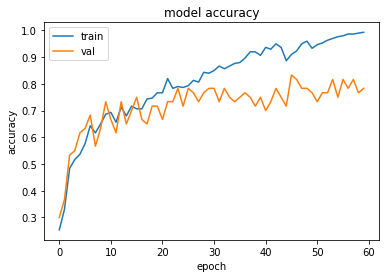

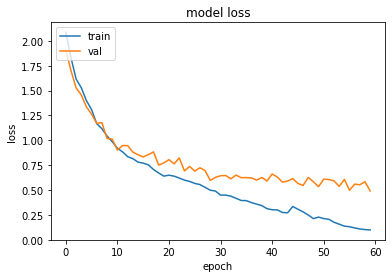

Time taken:  567.8040974140167


In [ ]:
with tf.device('/device:GPU:0'):
  batch_size=20
  nCNNfilters=170
  nLstmUnits=153
  epochs=60
  dim=(nSubsequences,nLookback,frameSize[0],frameSize[1],3)
  params = {'dim': dim,
            'batch_size': batch_size,
            'nLookback':nLookback,
            'nSubsequences':nSubsequences,
            'n_classes': 8,
            'shuffle': True}
  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)

  layers=list()
  layers.append(keras.layers.InputLayer(input_shape=(nSubsequences,nLookback,frameSize[0],frameSize[1],3)))
  layers.append(Lambda(lambda x:x/255))
  layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=nCNNfilters,kernel_size=(4,15,15),activation='tanh',trainable=True),input_shape=(nSubsequences,nLookback,frameSize[0],frameSize[1],3)))
  layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
  layers.append(tfKL.LSTM(units=nLstmUnits,activation='tanh',trainable=True))
  layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))
  # model=createModel(layers,optimizer=keras.optimizers.Adam(learning_rate=0.1))
  # model=createModel(layers,optimizer=keras.optimizers.RMSprop(learning_rate=0.01))
  # model=createModel(layers,optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta"))
  model=createModel(layers,optimizer=keras.optimizers.SGD(lr=0.07, nesterov=True))

  
  # x=Input(shape=(nSubsequences,nLookback,frameSize[0],frameSize[1],3))
  # x1=Lambda(lambda x:x/255)(x)
  # x2=tfKL.TimeDistributed(tfKL.Conv3D(filters=nCNNfilters,kernel_size=(4,10,10),trainable=True),input_shape=(nSubsequences,nLookback,frameSize[0],frameSize[1],3))(x1)
  # x3=tf.keras.activations.gelu(x2)
  # x4=tfKL.TimeDistributed((tfKL.Flatten()))(x3)
  # x5=tfKL.LSTM(units=nLstmUnits,trainable=True)(x4)
  # x55=tf.keras.activations.gelu(x5)
  # x6=tfKL.Dense(units=8,activation='softmax',trainable=True)(x55)
  # model=Model(inputs=x,outputs=x6)
  # model.compile(optimizer=keras.optimizers.SGD(lr=0.07, nesterov=True),metrics=['accuracy'],loss='categorical_crossentropy')

  begin=time.time()
  history=model.fit_generator(epochs=epochs,verbose=2,generator=training_generator,
                    validation_data=validation_generator,callbacks=[LossAndErrorPrintingCallback()])
  end=time.time()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
 
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print("Time taken: ",end-begin)

Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Epoch 1/10
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data generator:  (20, 5, 4, 80, 80, 3)
Batch end
Shape of X output by data gen

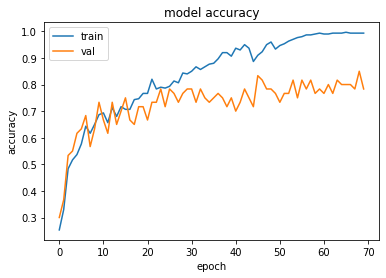

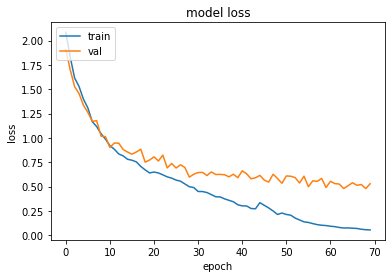

Time taken:  94.0828149318695


In [ ]:
with tf.device('/device:GPU:0'):
  epochs=10
  begin=time.time()
  history1=model.fit_generator(epochs=epochs,verbose=2,generator=training_generator,
                    validation_data=validation_generator,callbacks=[LossAndErrorPrintingCallback()])
  end=time.time()
  for keyw in ['loss','val_loss','accuracy','val_accuracy']:
    history.history[keyw]=history.history[keyw]+history1.history[keyw]

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print("Time taken: ",end-begin)

In [17]:
with tf.device('/device:GPU:0'):
  model=tf.keras.models.load_model("/content/gdrive/MyDrive/80cross80bbgNormalizedCL.h5")
  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 5, 4, 80, 80, 3)   0         
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 1, 66, 66, 170) 459170    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 740520)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 156)               462182448 
_________________________________________________________________
dense (Dense)                (None, 8)                 1256      
Total params: 462,642,874
Trainable params: 462,642,874
Non-trainable params: 0
_________________________________________________________________


In [18]:
def testAccuracy(Result,testSetY):
  diff=np.asarray(Result)-np.asarray(testSetY)
  answer=(((np.shape(diff))[0]-np.count_nonzero(diff)))/(np.shape(diff)[0])
  return answer

In [19]:
with tf.device('/device:GPU:0'):
  dim=(nSubsequences,nLookback,frameSize[0],frameSize[1],3)
  params = {'dim': dim,
            'batch_size': 1,
            'nLookback':nLookback,
            'nSubsequences':nSubsequences,
            'n_classes': 8,
            'shuffle': True}
  params1 = params
  params1['shuffle']=False
  params1['batch_size']=1
  testing_generator = DataGenerator(partition['test'], labels, **params1)
  res=model.predict_generator(testing_generator,callbacks=LossAndErrorPrintingCallback())

Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 

In [20]:
res2=np.argmax(res,axis=1)
print("Our prediction: ")
print(res2)
testY=[]
for el in partition['test']:
  testY.append(labels[el])
print("Truth: ")
print(testY)

Our prediction: 
[0 0 0 0 0 1 1 1 1 1 7 5 7 7 7 6 6 6 6 6 5 5 5 5 2 2 2 2 2 4 4 4 4 4 3 3 3
 3 3]
Truth: 
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3]


In [21]:
print(testAccuracy(res2,testY))

0.9743589743589743


In [22]:
total=len(partition['test'])
correct=int(total*testAccuracy(res2,testY))
incorrect=total-correct
print(total)
print(correct)
print(incorrect)

39
38
1


In [23]:
gc.collect()

203

In [ ]:
# with tf.device('/device:GPU:0'):
#   model.save("/content/gdrive/MyDrive/80cross80bbgNormalizedCL.h5")

In [24]:
with tf.device('/device:GPU:0'):
  testing_generator = DataGenerator(partition['test']+partition['train']+partition['validation'], labels, **params1)
  res=model.predict_generator(testing_generator,callbacks=LossAndErrorPrintingCallback())
  res2=np.argmax(res,axis=1)
  print("Our prediction: ")
  print(res2)
  testY=[]
  for el in partition['test']+partition['train']+partition['validation']:
    testY.append(labels[el])
  print("Truth: ")
  print(testY)
  print(testAccuracy(res2,testY))

Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 3)
Shape of X output by data generator:  (1, 5, 4, 80, 80, 